In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')


In [7]:
path = "InSDN_DatasetCSV/"

normal_df = pd.read_csv(f"{path}Normal_data.csv")
osv_df = pd.read_csv(f"{path}OVS.csv")
metasploit_df = pd.read_csv(f"{path}metasploitable-2.csv")
df = pd.concat([normal_df, osv_df, metasploit_df], ignore_index=True)



In [8]:
# Etiketlerdeki boşlukları ve büyük/küçük harf farklarını temizleyelim
df['Label'] = df['Label'].str.strip().str.lower()

# "ddos" etiketlerini birleştirip kontrol edelim
df['Label'] = df['Label'].replace('ddos', 'ddos')

# Etiketleri tekrar kontrol edelim
print(df['Label'].value_counts())

Label
ddos          121942
probe          98129
normal         68424
dos            53616
bfa             1405
web-attack       192
botnet           164
u2r               17
Name: count, dtype: int64


📊 En önemli 48 özellik ve önem dereceleri:
              Feature  Importance
0            Src Port    0.161096
1            Protocol    0.150848
2            Dst Port    0.138079
3      Bwd Header Len    0.129245
4        Flow IAT Max    0.066206
5        Bwd IAT Mean    0.039547
6   Init Bwd Win Byts    0.034183
7         Bwd IAT Tot    0.030970
8       Flow IAT Mean    0.030024
9         Bwd IAT Max    0.027112
10         Bwd Pkts/s    0.021494
11        Flow Pkts/s    0.019055
12        Pkt Len Max    0.017166
13      Flow Duration    0.016381
14       Tot Fwd Pkts    0.015674
15   Subflow Fwd Pkts    0.014857
16         Fwd Pkts/s    0.011748
17       Flow IAT Std    0.010377
18        Pkt Len Var    0.010326
19   Subflow Bwd Pkts    0.009439
20       SYN Flag Cnt    0.009109
21       Pkt Size Avg    0.006935
22       Pkt Len Mean    0.006752
23     Fwd Header Len    0.005574
24        Pkt Len Std    0.003401
25   Fwd Pkt Len Mean    0.003187
26       ACK Flag Cnt    0.002724
27   

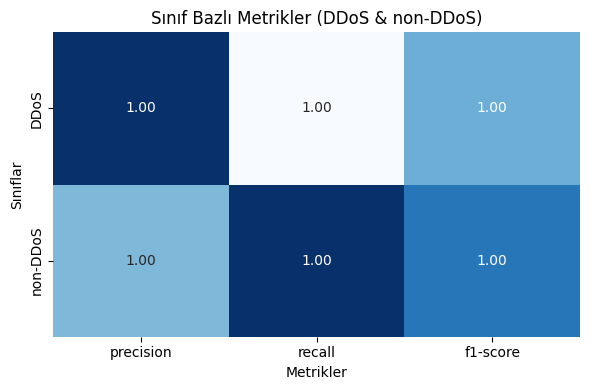

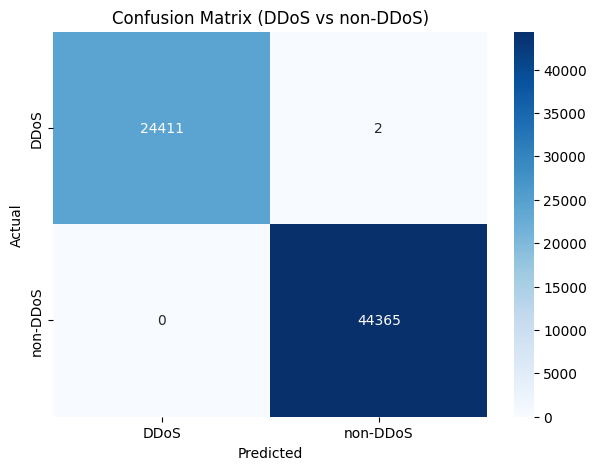

In [ ]:
#####EN ETKILI 48 ÖZELLİK SEÇIMI OTOMATIK

# --- 2. Verileri birleştir ---
df = pd.concat([normal_df, osv_df, metasploit_df], ignore_index=True)

# --- 3. Etiket temizliği ---
df['Label'] = df['Label'].str.strip().str.lower()
df['BinaryLabel'] = df['Label'].apply(lambda x: 'DDoS' if x == 'ddos' else 'non-DDoS')

# --- 4. Sayısal verileri al ---
numeric_df = df.select_dtypes(include=[np.number]).copy()
numeric_df['BinaryLabel'] = df['BinaryLabel']

# --- 5. Eksik verileri temizle ---
numeric_df = numeric_df.dropna()

# --- 6. Özellik ve etiket ayır ---
X_full = numeric_df.drop(columns=['BinaryLabel'])
y_full = numeric_df['BinaryLabel']

# --- 7. Geçici model ile tüm özellikleri eğit ---
temp_model = RandomForestClassifier(n_estimators=100, random_state=42)
temp_model.fit(X_full, y_full)

# --- 8. En önemli 48 özelliği seç ---
importances = pd.Series(temp_model.feature_importances_, index=X_full.columns)
top_48 = importances.sort_values(ascending=False).head(48)
top_48_features = top_48.index.tolist()

# Tablo formatında göster
top_48_df = pd.DataFrame({
    'Feature': top_48.index,
    'Importance': top_48.values
}).reset_index(drop=True)

print("📊 En önemli 48 özellik ve önem dereceleri:")
print(top_48_df)

# --- 9. Bu 48 özellikle yeni dataframe oluştur ---
X = numeric_df[top_48_features].copy()
y = numeric_df['BinaryLabel'].copy()

# --- 10. Eğitim / Test bölme ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 11. Nihai model eğitimi ---
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# --- 12. Tahmin ve sonuçlar ---
y_pred = rf_model.predict(X_test)

# --- 13. Sınıflandırma raporu ---
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Sadece DDoS ve non-DDoS sınıflarını al (accuracy vs macro avg vs weighted avg dahil değil)
filtered_report = report_df.loc[['DDoS', 'non-DDoS'], ['precision', 'recall', 'f1-score']]

# Isı haritasını çiz
plt.figure(figsize=(6, 4))
sns.heatmap(filtered_report, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.title("Sınıf Bazlı Metrikler (DDoS & non-DDoS)")
plt.xlabel("Metrikler")
plt.ylabel("Sınıflar")
plt.tight_layout()
plt.show()

# --- 14. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=['DDoS', 'non-DDoS'])

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['DDoS', 'non-DDoS'], yticklabels=['DDoS', 'non-DDoS'])
plt.title("Confusion Matrix (DDoS vs non-DDoS)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
0,0,0,0

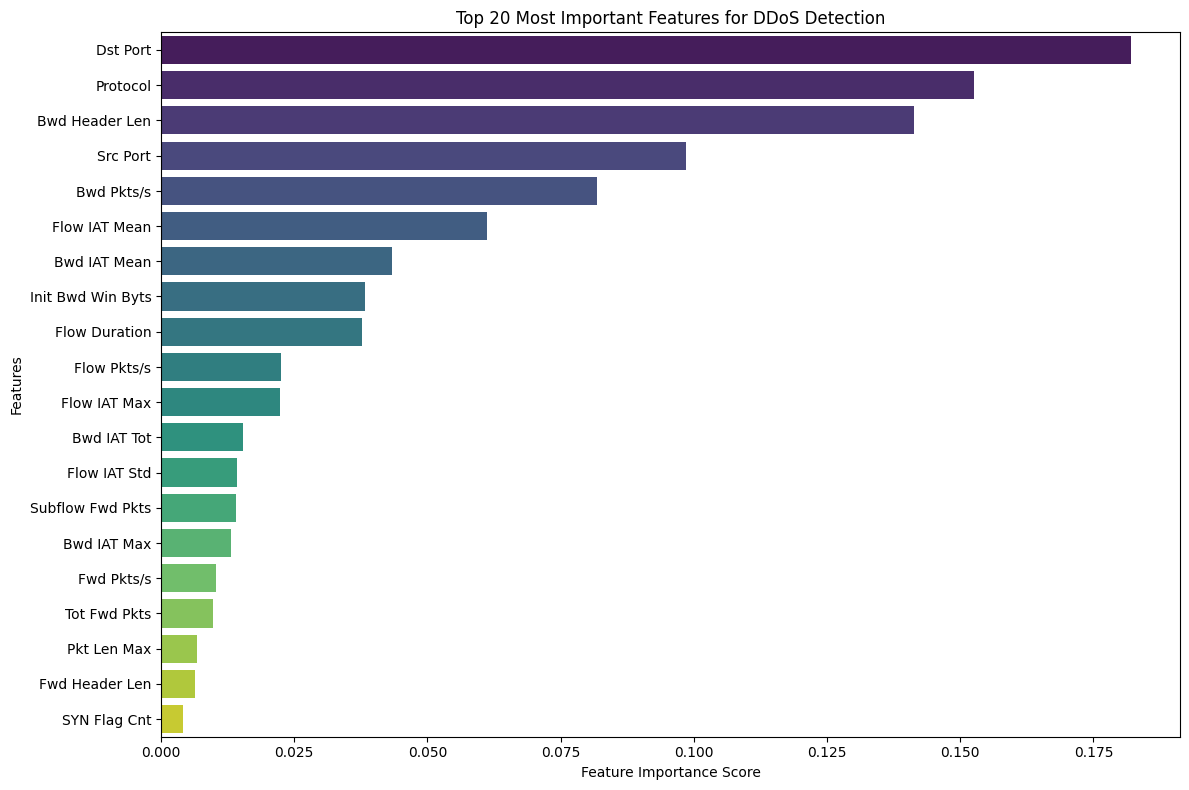

In [7]:
# Özelliklerin önem derecelerini alalım
importances = rf_model.feature_importances_

# Özellik isimleri ile birlikte DataFrame'e aktaralım
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
})

# Önem sırasına göre sıralayalım
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# En önemli ilk 20 özelliği görselleştirelim
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title("Top 20 Most Important Features for DDoS Detection")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


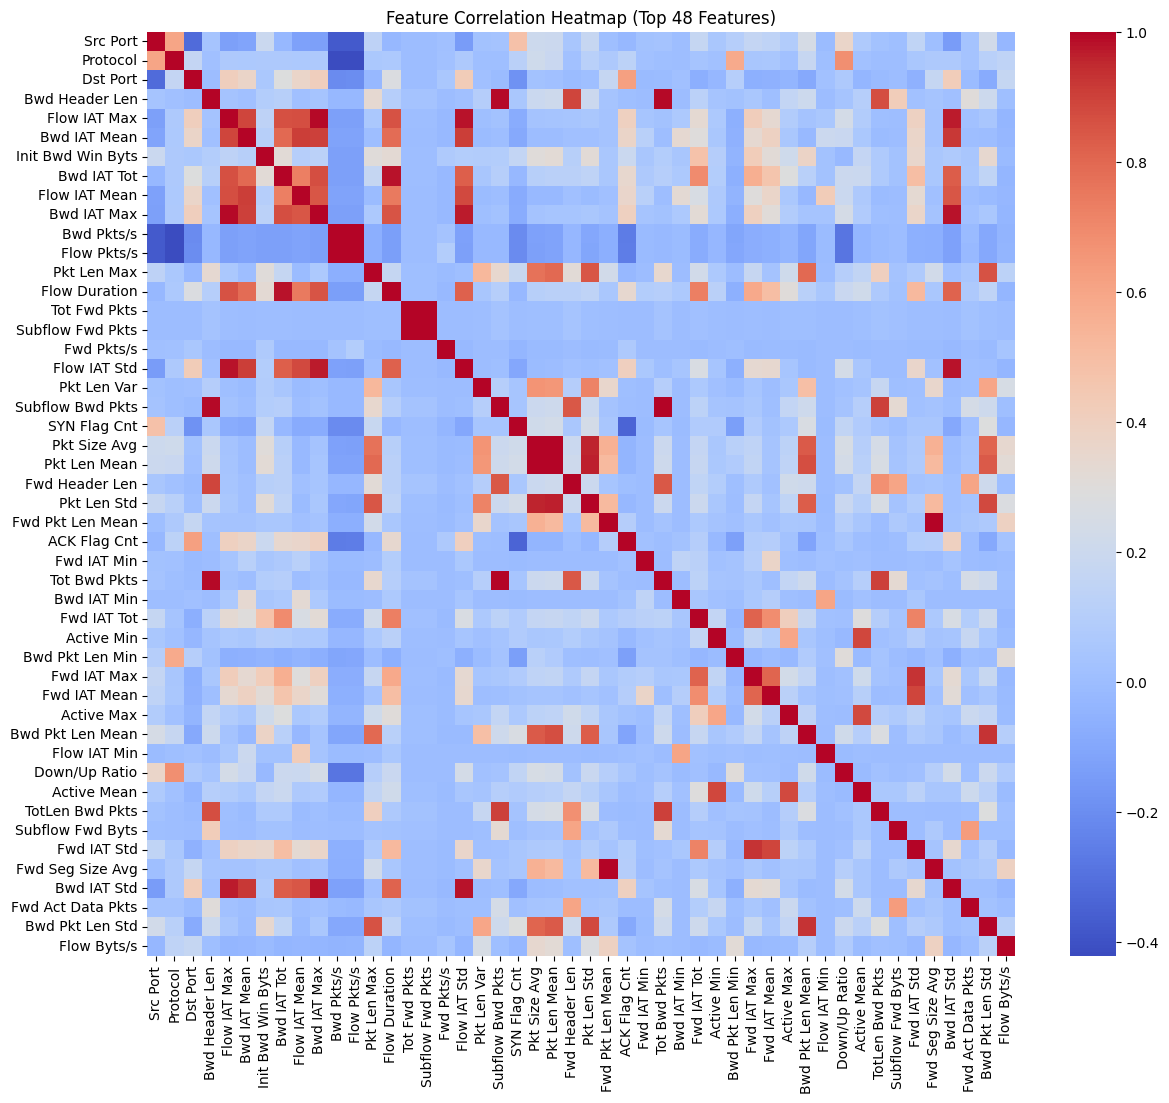

In [19]:
plt.figure(figsize=(14, 12))
sns.heatmap(df[top_48_features].corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Heatmap (Top 48 Features)")
plt.show()

In [15]:
import joblib
joblib.dump(rf_model, 'ddos_model.pkl')


['ddos_model.pkl']

In [ ]:
##DATASET BIRLEŞTIRME (BUNU CALISTIRMAK GEREKMIYOR)

import pandas as pd

# Dosyaları oku
normal = pd.read_csv(f"InSDN_DatasetCSV/Normal_data.csv")
ovs = pd.read_csv(f"InSDN_DatasetCSV/OVS.csv")
meta = pd.read_csv(f"InSDN_DatasetCSV/metasploitable-2.csv")

# Her birine kaynak etiketi ekle
normal['Source'] = 'normal'
ovs['Source'] = 'ovs'
meta['Source'] = 'metasploitable'

# Hepsini birleştir
combined = pd.concat([normal, ovs, meta], ignore_index=True)

# Tek bir CSV olarak kaydet (UTF-8, virgül ayraçlı)
combined.to_csv("combined_flows.csv", index=False, encoding="utf-8")


In [46]:
# --- Tahmin yapılacak input verisi ---
raw_input = "0,6,443,0,16.0,16.0,-1,16.0,16.0,16.0,125000.0,125000.0,0,16,0,0,0.0,0.0,0.0,2,0,0.0,0.0,0,0.0," \
"0.0,0,0,0,0,0,0,0.0,0.0,2,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0"

# --- Raw input'u dizi haline getirme ---
input_values = np.array([float(x) for x in raw_input.split(',')])

# --- DataFrame'e uygun formatta input verisini hazırlama ---
input_df = pd.DataFrame([input_values], columns=top_48_features)

# --- Tahmin yapma ---
prediction = rf_model.predict(input_df)

# --- Tahmin çıktısını ekrana yazdırma ---
print("Tahmin Sonucu:", prediction[0])

Tahmin Sonucu: DDoS
